In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

from clib.bellhop import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
s = bellhop({'mediterrannee': '../SSP_4profils.mat'},name='cognac_2000m_test',rmax=50.)

## Celerity profile choice 

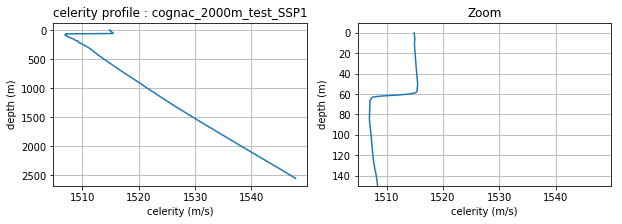

In [3]:
issp=0                                 # sound speed profile number
s.plotssp('mediterrannee', Issp=issp)

## Full calculations on this Mediterrannée profile 

- *Bathymetry* : flat bottom at 2000 m depth

- *Source* : one source at 100m depth at range 0km

- *Receivers* : **Depth : every 1m from 0 to 500m depth    /    Range : every 10m from 0 to 100 km **


In [4]:
# Generate .env file A

issp=0                                # sound speed profile number

s.params['file_type'] = 'A'           # 'E' : eigen rays (.rau) / 'A' : arrivals time and amplitude file (.arr)
s.params['zs'] = 100.                 # source depth
s.params['ALimites'] = [-90.0, 90.0]  # limit angles

s.params['NDepth'] = 501              # number of receiver depths
s.params['zmin'] = 0.                 # minimum depth (m)
s.params['zmax'] = 500.               # maximum depth (m) (unuseful if NDepth=1)
                 

s.params['NRange'] = 10001            # number of receiver range    
s.params['rmin'] = 0.                 # minimum range (km)
s.params['rmax'] = 100.               # maximum range (km) (unuseful if NRange=1)            

s.params['zbox'] = 2500.              # box depth limit 
s.params['rbox'] = 101.               # box range limit 

s.generate_envfile('mediterrannee',file_env = s.params['name']+'_A_full.env', Issp=issp, SSP_depth_step=10)


In [5]:
### read file .arr 
#Arr, Pos = s.read_arrivals_asc ('files_arr/cognac_2000m_test_A_full.arr', Narrmx = 15)
#s.save_dict('../Dictio', Arr, 'Arr1')
#s.save_dict('../Dictio', Pos, 'Pos1')

### reload saved dictionaries 
Arr, Pos = s.load_dict('../Dictio', 'Arr1'), s.load_dict('../Dictio', 'Pos1')

In [6]:
Nsd = np.shape(Pos['s']['depth'])[0]
Nrd = np.shape(Pos['r']['depth'])[0]
Nrr = np.shape(Pos['r']['range'])[0]

print('Number of source depths   : Nsd = ', Nsd)
print('Number of receiver depths : Nrd = ', Nrd)
print('Number of receiver ranges : Nrr = ', Nrr)

print ('\nTotal number of receivers : ', Nrr*Nrd)

Number of source depths   : Nsd =  1
Number of receiver depths : Nrd =  501
Number of receiver ranges : Nrr =  10001

Total number of receivers :  5010501


## Example of arrival chart

- In red : not reflected ray (only refracted)
- In blue : reflected only on the surface 
- In black : bottom-reflected ray 

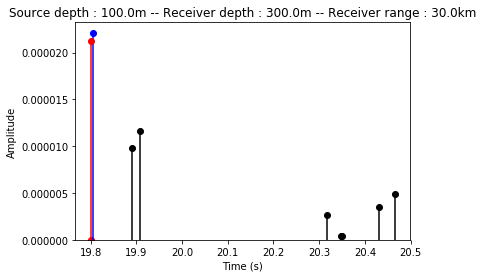

In [7]:
# example for one receiver

isd = 0       # choice of source depth (from 0 to Nsd-1)  
ird = 300     # choice of receiver depth (from 0 to Nrd-1)
irr = 3000    # choice of receiver range (from 0 to Nrr-1)

s.plotarr(Arr, Pos, irr, ird, isd)
#plt.xlim (xmin = 1.652, xmax = 1.6525)

## How to change Amplitude unit in dB ?? 

- We choose to work with **coherent TL** : the phase of the pressure is taken into account.
- We work with the **modulus of complex pressure** (and not only real part of it).  

In [8]:
Narr = int(Arr['Narr'][irr,ird,isd])

In [9]:
# sortie de la simulation (.arr)

A = Arr['A'][irr, :Narr, ird, isd]
print('Amplitude : \n', A)

db = -20.0 * np.log10 (abs(A)) 
print('\nAmplitude in dB : \n', db)

Amplitude : 
 [-4.91701365e-06  9.77235907e-06 -1.15907815e-05 -4.35306885e-07
  9.08574896e-22 -2.21201426e-05  3.54570822e-06  2.12531831e-05
 -4.35124358e-07  2.69460716e-06]

Amplitude in dB : 
 [106.16597173 100.20001168  98.71774561 127.22408928 420.83278534
  93.10424155 109.00594011  93.45152032 127.2277321  111.39009081]


In [10]:
# méthode donnée dans makeshdarr.m

freq = np.array([3000])
omega = 2 * np.pi * freq
if Narr > 0 :
    pressure = Arr['A'][irr, :Narr, ird, isd] * np.exp(-1j * omega * Arr['delay'][irr, :Narr, ird, isd])

In [11]:
#résultat 
pressure

array([-4.81169566e-06+1.01222926e-06j, -9.14366354e-06+3.44853864e-06j,
       -5.37856651e-06-1.02672897e-05j, -2.26513678e-07+3.71730598e-07j,
       -4.98828350e-22-7.59393587e-22j,  9.21661435e-06+2.01085735e-05j,
        2.12178195e-06+2.84079005e-06j, -4.13974154e-06+2.08461107e-05j,
       -4.34459394e-07+2.40466524e-08j,  2.55637266e-06-8.51978036e-07j])

In [12]:
# module (COHERENT)
TL = -20.0 * np.log10 (abs(pressure)) 
TL

array([106.16597173, 100.20001168,  98.71774561, 127.22408928,
       420.83278534,  93.10424155, 109.00594011,  93.45152032,
       127.2277321 , 111.39009081])

In [13]:
#partie réelle uniquement (INCOHERENT)
TLreal = -20.0 * np.log10 (abs(pressure.real)) 
TLreal

array([106.35403699, 100.77759526, 105.38666913, 132.89811136,
       426.04097745, 100.70857168, 113.46598498, 107.66053545,
       127.24101616, 111.84751672])

# I - Detection by maximum amplitude

- We plot maps of amplitude where values are corresponding to the maximum of amplitude detected by the receiver. 
- They have the same shapes than maps from TL directly calculated by Bellhop (.shd).


In [14]:
Max_A = np.zeros( (Nrr, Nrd, Nsd) )
for isd1 in range (Nsd):
    for ird1 in range (Nrd) : 
        for irr1 in range (Nrr) :
            Narr = int(Arr['Narr'][irr1, ird1, isd1])
            if not Narr ==0 :
                A = abs(Arr['A'][irr1, :Narr, ird1, isd1])
                maxA = A[np.where(A==np.max(A))][0]
                Max_A[irr1,ird1,isd1] = maxA

## A - Amplitude and Received level (RL) maps 

Maximum amplitude is 0.096


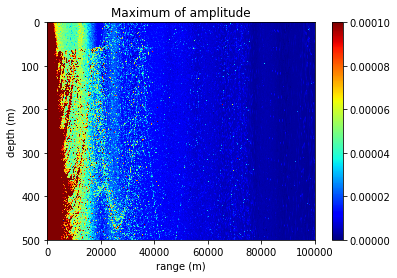

In [15]:
isd = 0    # source number (only 1 source here)
R = Pos['r']['range']
Z = Pos['r']['depth']
plt.pcolormesh(R, Z, Max_A[:,:,isd].T, cmap='jet')
plt.title ('Maximum of amplitude')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
plt.clim([0,1e-4])
plt.gca().invert_yaxis()

print("Maximum amplitude is %.3f" %np.max(Max_A[:,:,isd]))

### Transmission Loss (dB)

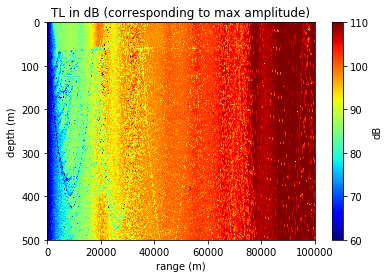

In [16]:
Max_A_dB  = -20.0*np.log10( Max_A )
plt.pcolormesh(R, Z, Max_A_dB[:,:,isd].T, cmap='jet')
plt.title ('TL in dB (corresponding to max amplitude)')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dB")
plt.clim([60,110])
plt.gca().invert_yaxis()


### Received level (dB) 

In [17]:
# sonar equation
SL = 185                 # Souce level (dB)
TL = Max_A_dB            # Transmission loss (dB)
NL = 81.7                # Noise level (dB)
DI = 0                   # Directivity index (dB)

B = 200                  # bandwidth (Hz)
T = 1                    # transmitted signal duration (s)
PG = 10.0*np.log10(B*T)  # Processing gain (dB)

RT  = SL - TL - NL + DI + PG 

Maximum received level is 105.9 dB.


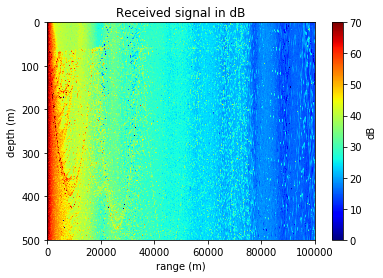

In [18]:
plt.pcolormesh(R, Z, RT[:,:,isd].T, cmap='jet')
plt.title ('Received signal in dB')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dB")
plt.clim([0,70])
plt.gca().invert_yaxis()

print("Maximum received level is %.1f dB." %np.max(RT[:,:,isd]))

In [19]:
RTmin = 10   # Min reception treshold (dB)

tot = np.shape(RT)[0]*np.shape(RT)[1]
detected = np.shape(np.where(RT>RTmin)[0])[0]
pourcent = detected*100./tot

print('The received level (RT) is big enough (>10dB) to be detected in %.1f percents of cases.' %pourcent)

The received level (RT) is big enough (>10dB) to be detected in 99.9 percents of cases.


## B -  Max of amplitude : direct ray  or bottom-reflected ray ?

### direct or not ?

Is the ray with the amplitude max a direct ray or a bottom-reflected one ? 

In [20]:
# for all sources and all receivers
# Dir : direct : -1 // reflechis fond : 1 ou nbre de reflections
# Nb_ref : nbre de reflections 

c = 1500     # celerity (m/s)
Dir = np.zeros( (Nrr, Nrd, Nsd) )
Nb_ref = np.zeros( (Nrr, Nrd, Nsd) )

for isd1 in range (Nsd):
    for ird1 in range (Nrd) : 
        for irr1 in range (Nrr) :
            Narr = int(Arr['Narr'][irr1, ird1, isd1])
            if not Narr ==0 :
                A = abs(Arr['A'][irr1, :Narr, ird1, isd1])
                NumBotBnc = Arr['NumBotBnc'][irr1,:Narr, ird1, isd1]
                NumTopBnc = Arr['NumTopBnc'][irr1,:Narr, ird1, isd1]
                n_bot_max = NumBotBnc[np.where(A==np.max(A))][0]  # NumBotBnc of ray with max of amplitude
                n_top_max = NumTopBnc[np.where(A==np.max(A))][0]
                
                Nb_ref [irr1, ird1, isd1] = n_bot_max + n_top_max
                if n_bot_max ==0 :
                    Dir [irr1, ird1, isd1] = -1
                else : 
                    Dir [irr1,ird1,isd1] = 1
                

We work with 5010501 receivers.


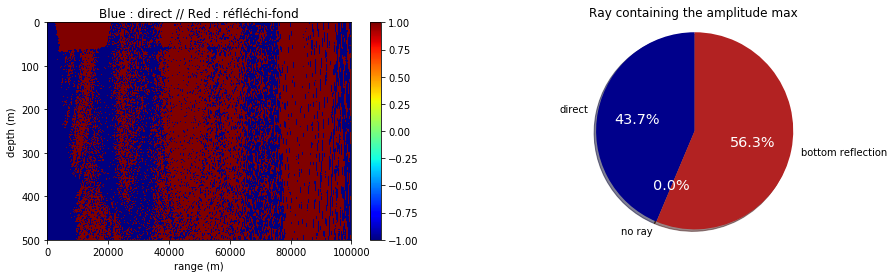

In [21]:
isd = 0    # source number (only 1 source here)

##
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
R = Pos['r']['range']
Z = Pos['r']['depth']
plt.pcolormesh(R, Z, Dir[:,:,isd].T, cmap='jet')
plt.title ('Blue : direct // Red : bottom-reflected')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
plt.gca().invert_yaxis()

##
plt.subplot(1,2,2)
tot = np.shape(Dir)[0]*np.shape(Dir)[1]
print('We work with %d receivers.' %tot)
direct = np.shape( np.where(Dir==-1)[0] )[0]
no_ray = np.shape( np.where(Dir==0)[0] )[0]
bot_ref = np.shape( np.where(Dir>=1)[0] )[0]
name = ['direct', 'no ray', 'bottom reflection']
data = [direct, no_ray, bot_ref]
patches, texts, autotexts = plt.pie(data, labels=name, \
                                    colors=['darkblue','y','firebrick'], \
                                    autopct='%1.1f%%', startangle=90, shadow=True)  
for t in autotexts:
    t.set_color('w')
    t.set_size('x-large')
plt.axis('equal')
plt.title ('Ray containing the amplitude max')
plt.show()

### Number of reflexions

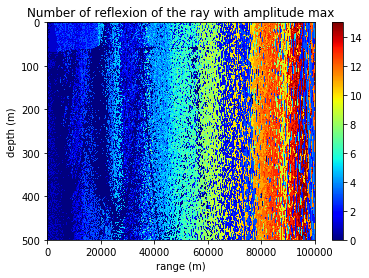

In [22]:
plt.pcolormesh(R, Z, Nb_ref[:,:,isd].T, cmap='jet')
plt.title ('Number of reflexion of the ray with amplitude max')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
plt.gca().invert_yaxis()

### If reflected ray : what is the difference of amplitude with the direct ray ? 

In [23]:
# direct : 1 // reflechis fond : -1
# for all sources and all receivers
# not in dB ... 

c = 1500     # celerity (m/s)
Diff_A = np.zeros( (Nrr, Nrd, Nsd) )

for isd1 in range (Nsd):
    print('source number : ', isd1)
    for ird1 in range (Nrd) : 
        #print('%d/%d' %(ird1,Nrd))
        for irr1 in range (Nrr) :
            Narr = int(Arr['Narr'][irr1, ird1, isd1])
            if not Narr ==0 :
                A = abs(Arr['A'][irr1, :Narr, ird1, isd1])
                NumBotBnc = Arr['NumBotBnc'][irr1,:Narr, ird1, isd1]
                nmax_R = NumBotBnc[np.where(A==np.max(A))][0]  # NumBotBnc of ray with max of amplitude
                
                if nmax_R ==0 :
                    Diff_A [irr1, ird1, isd1] = 0
                    
                else : 
                    Amp_max = A[np.where(A==np.max(A))][0]
                    Amp_D= A[np.where(NumBotBnc==0)]
                    if len(Amp_D)>0 : 
                        Amp_D_max = Amp_D[np.where(Amp_D==np.max(Amp_D))][0]
                        
                        Diff_A [irr1, ird1, isd1] = np.min([Amp_max/Amp_D_max,100])  # ratio reflected / direct 
                    else : 
                        Diff_A [irr1, ird1, isd1] = 100

source number :  0


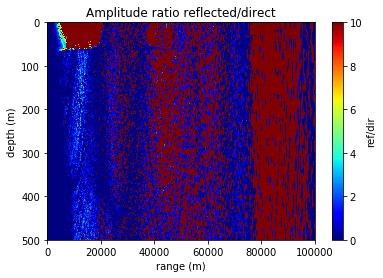

In [24]:
isd = 0    # source number (only 1 source here)

R = Pos['r']['range']
Z = Pos['r']['depth']
plt.pcolormesh(R, Z, Diff_A[:,:,isd].T, cmap='jet')
plt.title ('Amplitude ratio reflected/direct')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("ref/dir")
plt.clim([0,10])
plt.gca().invert_yaxis()

- Working with a detection by maximum amplitude seems to be complicated : less than 50% of the detected rays are direct. When we'll work with equivalent celerity well have huge errors (see "Celerity_map" notebook). 


- Woking with a **detection treshold** might be better. 


# II - Detection treshold (instead of max of amplitude)

In [25]:
# sonar equation
SL = 185                 # Souce level (dB)
NL = 81.7                # Noise level (dB)
DI = 0                   # Directivity index (dB)

B = 200                  # bandwidth (Hz)
T = 1                    # transmitted signal duration (s)
PG = 10.0*np.log10(B*T)  # Processing gain (dB)

#RT  = SL - TL - NL + DI + PG 

## A - Received Level (dB)

In [26]:
seuil_d = 10

In [27]:
RL_first = np.zeros( (Nrr, Nrd, Nsd) )
Dir1 = np.zeros( (Nrr, Nrd, Nsd) )
Nb_ref1 = np.zeros( (Nrr, Nrd, Nsd) )

for isd1 in range (Nsd):
    for ird1 in range (Nrd) : 
        for irr1 in range (Nrr) :
            Narr = int(Arr['Narr'][irr1, ird1, isd1])
            if not Narr ==0 :
                NumBotBnc = Arr['NumBotBnc'][irr1,:Narr, ird1, isd1]
                NumTopBnc = Arr['NumTopBnc'][irr1,:Narr, ird1, isd1]
                A = abs(Arr['A'][irr1, :Narr, ird1, isd1])  # amplitude 
                TL = - 20.0*np.log10(A)
                RL = SL - TL - NL +DI + PG    # received level 
                t = Arr['delay'][irr1, :Narr, ird1, isd1]
                t_ok = t[np.where(RL > seuil_d)]
                
                
                if len(t_ok > 0): 
                    t_min = np.min(t_ok)
                    RL_first [irr1,ird1,isd1] = RL[np.where(t==t_min)][0]
                    
                    nbot_first = NumBotBnc[np.where(t==t_min)][0]         # NumBotBnc of first ray detected
                    ntop_first = NumTopBnc[np.where(t==t_min)][0]         # NumTopBnc of first ray detected
                    Nb_ref1 [irr1, ird1, isd1] = nbot_first + ntop_first  # total number of reflections
                
                    if nbot_first ==0 :
                        Dir1 [irr1, ird1, isd1] = -1   # direct ray 
                    else : 
                        Dir1 [irr1,ird1,isd1] = 1      # bottom-reflected ray                  
                
                else : 
                    RL_first [irr1,ird1,isd1] = np.NaN
                    Dir1 [irr1,ird1,isd1] = np.NaN
                    Nb_ref1 [irr1,ird1,isd1] = np.NaN
                    
            else : 
                RL_first [irr1,ird1,isd1] = np.NaN
                Dir1 [irr1,ird1,isd1] = np.NaN
                Nb_ref1 [irr1,ird1,isd1] = np.NaN

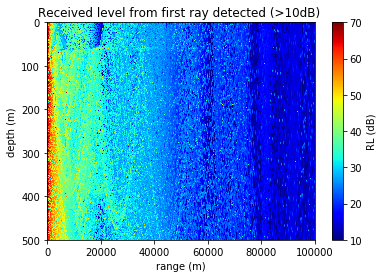

In [28]:
isd = 0    # source number (only 1 source here)

R = Pos['r']['range']
Z = Pos['r']['depth']
plt.pcolormesh(R, Z, RL_first[:,:,isd].T, cmap='jet')
plt.title ('Received level from first ray detected (>%ddB) ' %seuil_d)
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("RL (dB)")
plt.clim([10,70])
plt.gca().invert_yaxis()


## B - First arrival detected : direct ray or bottom reflected one ?

We work with 5010501 receivers.


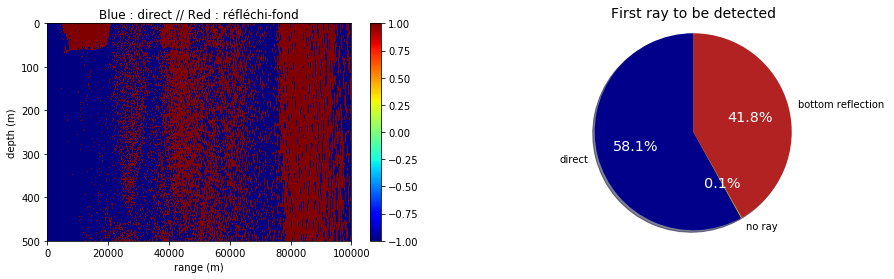

In [29]:
##
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.pcolormesh(R, Z, Dir1[:,:,isd].T, cmap='jet')
plt.title ('Blue : direct // Red : bottom_reflected')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
plt.gca().invert_yaxis()

##
plt.subplot(1,2,2)
tot = np.shape(Dir1)[0]*np.shape(Dir1)[1]
print('We work with %d receivers.' %tot)
direct = np.shape( np.where(Dir1==-1)[0] )[0]
no_ray = np.shape(np.where(np.isnan(Dir1)))[1]
bot_ref = np.shape( np.where(Dir1>=1)[0] )[0]
name = ['direct', 'no ray', 'bottom reflection']
data = [direct, no_ray, bot_ref]
patches, texts, autotexts = plt.pie(data, labels=name, \
                                    colors=['darkblue','y','firebrick'], \
                                    autopct='%1.1f%%', startangle=90, shadow=True)  
for t in autotexts:
    t.set_color('w')
    t.set_size('x-large')
plt.axis('equal')
plt.title ('First ray to be detected', fontsize=14)
plt.show()

We work with 802401 receivers.


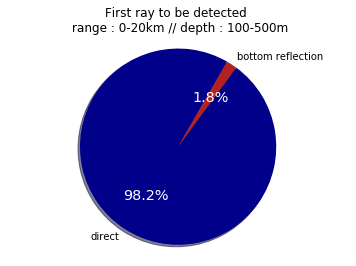

In [30]:
# sur les 20 premiers km, entre 100 et 500m 
Zoom_Dir1 = Dir1 [0:2001,100:,:]

tot = np.shape(Zoom_Dir1)[0]*np.shape(Zoom_Dir1)[1]
print('We work with %d receivers.' %tot)
direct = np.shape( np.where(Zoom_Dir1==-1)[0] )[0]
no_ray = np.shape(np.where(np.isnan(Zoom_Dir1)))[1]
bot_ref = np.shape( np.where(Zoom_Dir1==1)[0] )[0]
name = ['direct', 'bottom reflection']
data = [direct, bot_ref]
patches, texts, autotexts = plt.pie(data, labels=name, colors=['darkblue','firebrick'], \
                                    autopct='%1.1f%%', startangle=60, shadow=True)  
for t in autotexts:
    t.set_color('w')
    t.set_size('x-large')
plt.axis('equal')
plt.title ('First ray to be detected \n range : 0-20km // depth : 100-500m')
plt.show()

- Better results working with detection treshold, but still 40% of rays are bottom-reflected rays. 


- On the first 20km we obtain satisfying results.

# III - Error dx on distance if max amplitude is used instead of first detection

In [31]:
# error dx for all sources and all receivers

c = 1500     # celerity (m/s)
DX = np.zeros( (Nrr, Nrd, Nsd) )

for isd1 in range (Nsd):
    for ird1 in range (Nrd) : 
        for irr1 in range (Nrr) :
            Narr = int(Arr['Narr'][irr1, ird1, isd1])
            if not Narr ==0 :
                
                A = abs(Arr['A'][irr1, :Narr, ird1, isd1])  # amplitude 
                TL = - 20.0*np.log10(A)
                RL = SL - TL - NL +DI + PG    # received level
                t = Arr['delay'][irr1, :Narr, ird1, isd1]
                t_max = t[np.where(A==np.max(A))][0]      # time of arrival of max of amplitude 
                
                t_ok = t[np.where(RL > seuil_d)]
                if len(t_ok > 0): 
                    t_seuil = np.min(t_ok)                # time of arrival of first detected ray 
                    dx = c * (t_max - t_seuil)
                    DX [irr1,ird1,isd1] = dx           
                
                else : 
                    DX [irr1,ird1,isd1] = np.NaN     
            else : 
                DX [irr1,ird1,isd1] = np.NaN

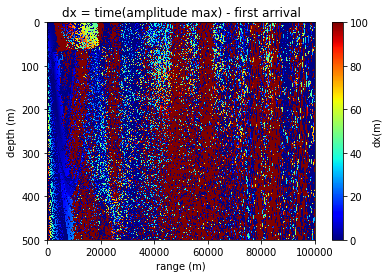

In [32]:
isd = 0    # source number (only 1 source here)

R = Pos['r']['range']
Z = Pos['r']['depth']
plt.pcolormesh(R, Z, DX[:,:,isd].T, cmap='jet')
plt.title ('dx = time(amplitude max) - first arrival')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dx(m)")
plt.clim ([0,100])
plt.gca().invert_yaxis()

Useful plot ??? 